In [842]:
from spyder.plugins.help.utils.sphinxify import loading
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import QuantLib as ql
import datetime

from zope.interface.interface import fromMethod

## Datasets

In [843]:
data = pd.read_parquet('/Users/vittoriomanfriani/Desktop/bonds_us.pq')

In [844]:
def get_issuedt(df):
    # print(df)
    dates = df.index.get_level_values(0)
    # print(dates)
    start_dt = dates.min()
    # print(start_dt)
    return start_dt
first_datapoints = data.groupby(level=1, axis=0).apply(get_issuedt)
first_datapoints.name = 'first_datapoint'

data = data.join(first_datapoints, on='id')

data.head()

price  yield  dv01  coupon   maturity  \
timestamp  id                                                         
2000-01-03 US912810BU17  100.812500  5.895   NaN   8.250 2005-05-15   
           US912810BX55  101.625000  6.781   NaN   7.625 2007-02-15   
           US912810BZ04  102.734375  6.803   NaN   7.875 2007-11-15   
           US912810CC00  104.968750  6.797   NaN   8.375 2008-08-15   
           US912810CE65  106.453125  6.817   NaN   8.750 2008-11-15   

                        first_datapoint  
timestamp  id                            
2000-01-03 US912810BU17      2000-01-03  
           US912810BX55      2000-01-03  
           US912810BZ04      2000-01-03  
           US912810CC00      2000-01-03  
           US912810CE65      2000-01-03

In [845]:
# Convert 'maturity' to datetime
data['maturity'] = pd.to_datetime(data['maturity'], errors='coerce')

# Drop rows where the 'maturity' is NaT (missing)
data = data.dropna(subset=['maturity'])

# Compute time to maturity
data.reset_index(inplace=True)
data['time to maturity'] = (data['maturity'] - data['timestamp']) / pd.Timedelta(days=365.25)

# Get time to maturities dataset
time_to_maturities = data.pivot(index='timestamp', columns='id', values='time to maturity')
time_to_maturities.index = pd.to_datetime(time_to_maturities.index)
issue_dates = data.pivot(index='timestamp', columns='id', values='first_datapoint')

# Get maturities dataset
maturities_dates = data.pivot(index='timestamp', columns='id', values='maturity')
maturities_dates.index = pd.to_datetime(maturities_dates.index)

In [846]:
time_to_maturities = time_to_maturities.iloc[-650:-50]
maturities_dates = maturities_dates.iloc[-650:-50]
issue_dates = issue_dates.iloc[-650:-50]

In [847]:
# Function to check single NaN in each column
def is_single_nan(series):
    mask = series.isna()
    # Single NaN is identified as a NaN surrounded by non-NaNs
    return mask & ~mask.shift(1, fill_value=False) & ~mask.shift(-1, fill_value=False)

In [848]:
# Mask for single NaNs
single_nan_mask_maturities = time_to_maturities.apply(is_single_nan)
single_nan_mask_maturity_dates = maturities_dates.apply(is_single_nan)

time_to_maturities = time_to_maturities.where(~single_nan_mask_maturities, time_to_maturities.interpolate(method='linear', limit=1, axis=0))
maturities_dates = maturities_dates.where(~single_nan_mask_maturity_dates, maturities_dates.interpolate(method='linear', limit=1, axis=0))

In [849]:
# Get other datasets

# First we get a dataset of prices
prices = pd.read_csv('/Users/vittoriomanfriani/Desktop/prices.csv')
prices.set_index('timestamp', inplace=True)
prices.index = pd.to_datetime(prices.index)
# Then we get a dataset of coupons
coupons = data.pivot(index='timestamp', columns='id', values='coupon')
coupons.index = pd.to_datetime(coupons.index)

In [850]:
prices = prices.iloc[-650:-50]
coupons = coupons.iloc[-650:-50]

In [851]:
# Before proceeding we interpolate nans only if there is one consecutive

# apply the function both to prices and coupons dataset

# Mask for single NaNs
single_nan_mask_coupons = prices.apply(is_single_nan)

coupons = coupons.where(~single_nan_mask_coupons, coupons.interpolate(method='linear', limit=1, axis=0))

In [852]:
# Get yield dataset
yields = pd.read_csv('/Users/vittoriomanfriani/Desktop/yields.csv')
yields.set_index('timestamp', inplace=True)
yields.index = pd.to_datetime(yields.index)
yields = yields.iloc[-650:-50]

## Nelson Siegel Model

In [853]:
# Apply Nelson-Siegel Model
def nelson_siegel(params, maturities, lambd):
    beta0, beta1, beta2 = params
    t = maturities
    alpha_1 = (1 - np.exp(-t/lambd))/(t/lambd)
    alpha_2 = (1 - np.exp(-t/lambd))/(t/lambd) - np.exp(-t/lambd)
    return beta0 + beta1 * alpha_1 + beta2 * alpha_2

In [854]:
# Error function to minimize to find optimal params
def error_function(params, maturities, data, lambd):
    data_hat = nelson_siegel(params, maturities, lambd)
    return np.sum((data - data_hat) ** 2)

# We define ridge error function as
def ridge_error_function(params, maturities, data, lambd, alpha=0.1):
    data_hat = nelson_siegel(params, maturities, lambd)
    error = np.sum((data - data_hat) ** 2) 
    regularization = alpha * (params[0]**2 + params[1]**2 + params[2]**2) 
    return error + regularization

In [855]:
# Apply Nelson-Siegel Model to the dataset
def apply_nelson_siegel(yields, maturities, lambdas = list(np.linspace(0.027, 1, 10)), ridge = False, alpha = 0.1):

    # Store results in a DataFrame
    fitted_results = []
    test_metrics = []
    
    initial_params = [0.03, -0.01, 0.01] 
    
    # Append arbitrary values to the list of possible lambdas 
    # (1.37 is the one that reflects best the curvature of 
    # the yield curve and 3 is the one that handles best multicollinearity)
    lambdas.append(1.37)
    lambdas.append(3)

    for i in range(yields.shape[0]):
        date = yields.index[i]
        current_yields = yields.iloc[i].dropna()
        current_maturities = maturities.iloc[i].dropna()
        
        # Align indices of current_yields and current_maturities
        valid_indices = current_yields.index.intersection(current_maturities.index)
        current_yields = current_yields.loc[valid_indices]
        current_maturities = current_maturities.loc[valid_indices]
        
        # Split data into train and test sets (80% train, 20% test)
        train_maturities, test_maturities, train_yields, test_yields = train_test_split(
            current_maturities, current_yields, test_size=0.2, random_state=42, shuffle= False
        )
        
        # Initialize variables to store best parameters
        best_loss = float("inf")
        best_params = None
        best_lambda = None

        # Grid search over lambda
        for lambd in lambdas:
            
            if ridge == False:
                result = minimize(
                    error_function,
                    initial_params,
                    args=(train_maturities, train_yields, lambd),  
                    method="L-BFGS-B",
                    options={'maxiter': 1000}, 
                )
            
            if ridge == True:
                # Grid Search over lambdas
                result = minimize(
                    ridge_error_function,
                    initial_params,
                    args=(train_maturities, train_yields, lambd, alpha),
                    method="L-BFGS-B",
                    options={'maxiter': 1000}  
                )
            # Update best parameters and lambda if this result is better
            if result.fun < best_loss:
                best_loss = result.fun
                best_params = result.x
                best_lambda = lambd
        
        # Compute predictions on the test set
        test_predictions = nelson_siegel(best_params, test_maturities, best_lambda)
        
        # Compute R^2
        ss_res = np.sum((test_yields - test_predictions) ** 2)  
        ss_tot = np.sum((test_yields - np.mean(test_yields)) ** 2) 
        r_squared = 1 - (ss_res / ss_tot)
        
        # Compute Mean Squared Error
        mse = mean_squared_error(test_yields, test_predictions)

        # Store results for the current date
        fitted_results.append({
            "Date": date,
            "Beta0 (Level)": best_params[0],
            "Beta1 (Slope)": best_params[1],
            "Beta2 (Curvature)": best_params[2],
            "Lambda": best_lambda, 
        })
        
        test_metrics.append({
            "Date": date,
            "R^2": r_squared,
            "MSE": mse,
        })

    # Convert results to a DataFrame
    fitted_results_df = pd.DataFrame(fitted_results)
    test_metrics_df = pd.DataFrame(test_metrics)
    
    fitted_results_df.set_index('Date', inplace=True)
    test_metrics_df.set_index('Date', inplace=True)

    return fitted_results_df, test_metrics_df

In [856]:
# Optimization problems without grid search but treating lambda as another parameter to optimize

# Updated Nelson-Siegel model
def nelson_siegel_lambd(params, maturities):
    beta0, beta1, beta2, lambd = params
    
    # set a min value for lambda to account for 0 division in optimization problems
    lambd = max(lambd, 1e-6)
    
    t = maturities
    
    alpha_1 = (1 - np.exp(-t/lambd))/(t/lambd)
    alpha_2 = (1 - np.exp(-t/lambd))/(t/lambd) - np.exp(-t/lambd)
    return beta0 + beta1 * alpha_1 + beta2 * alpha_2

# Error function to minimize to find optimal params
def error_function_lambd(params, maturities, data):
    data_hat = nelson_siegel_lambd(params, maturities)
    return np.sum((data - data_hat) ** 2)

# We define ridge error function as
def ridge_error_function_lambd(params, maturities, data, alpha=0.1):
    data_hat = nelson_siegel_lambd(params, maturities)
    error = np.sum((data - data_hat) ** 2) 
    regularization = alpha * (params[0]**2 + params[1]**2 + params[2]**2 + params[3]**2) 
    return error + regularization


# Fit the model to the data and get performance metrics
def apply_nelson_siegel_lambd(yields, maturities, ridge = False, alpha = 0.1):

    # Store results in a DataFrame
    fitted_results = []
    test_metrics = []
    
    initial_params = [0.01, 0.01, 0.01, 1] 

    for i in range(yields.shape[0]):
        date = yields.index[i]
        current_yields = yields.iloc[i].dropna()
        current_maturities = maturities.iloc[i].dropna()
        
        # Align indices of current_yields and current_maturities
        valid_indices = current_yields.index.intersection(current_maturities.index)
        current_yields = current_yields.loc[valid_indices]
        current_maturities = current_maturities.loc[valid_indices]
        
        # Split data into train and test sets (80% train, 20% test)
        train_maturities, test_maturities, train_yields, test_yields = train_test_split(
            current_maturities, current_yields, test_size=0.2, random_state=42, shuffle= False
        )
        if ridge == False:
            result = minimize(
                    error_function_lambd,
                    initial_params,
                    args=(train_maturities, train_yields),  
                    method="L-BFGS-B",
                    options={'maxiter': 1000}, 
                )
            
        if ridge == True:
            result = minimize(
                    ridge_error_function_lambd,
                    initial_params,
                    args=(train_maturities, train_yields, alpha),  
                    method="L-BFGS-B",
                    options={'maxiter': 1000}, 
                )
        
        params = result.x
        
        # Compute predictions on the test set
        test_predictions = nelson_siegel_lambd(params, test_maturities,)
        
        # Compute R^2
        ss_res = np.sum((test_yields - test_predictions) ** 2)  
        ss_tot = np.sum((test_yields - np.mean(test_yields)) ** 2) 
        r_squared = 1 - (ss_res / ss_tot)
        
        # Compute Mean Squared Error
        mse = mean_squared_error(test_yields, test_predictions)

        # Store results for the current date
        fitted_results.append({
            "Date": date,
            "Beta0 (Level)": params[0],
            "Beta1 (Slope)": params[1],
            "Beta2 (Curvature)": params[2],
            "Lambda": params[3], 
        })
        
        test_metrics.append({
            "Date": date,
            "R^2": r_squared,
            "MSE": mse,
        })

    # Convert results to a DataFrame
    fitted_results_df = pd.DataFrame(fitted_results)
    test_metrics_df = pd.DataFrame(test_metrics)
    fitted_results_df.set_index('Date', inplace=True)
    test_metrics_df.set_index('Date', inplace=True)

    return fitted_results_df, test_metrics_df

## Run Nelson Siegel Model

In [857]:
params, metrics = apply_nelson_siegel_lambd(yields, time_to_maturities, ridge=False)

In [858]:
params_ridge, metrics_ridge = apply_nelson_siegel_lambd(yields,time_to_maturities, ridge = True)

In [859]:
print('OLS metrics\n', metrics.mean())
print('Ridge metrics\n',metrics_ridge.mean())

OLS metrics
 R^2    0.647721
MSE    0.007110
dtype: float64
Ridge metrics
 R^2    0.617229
MSE    0.008688
dtype: float64


In [860]:
# Function to extract evenly spread values
def extract_evenly_spread_data(ttm_df, yield_df, num_points=15, ttm_range=(1, 30)):
    # Select the row corresponding to the date
    ttm_row = ttm_df.iloc[289]
    yield_row = yield_df.iloc[289]
    
    # Define the evenly spaced time to maturities
    evenly_spread_ttm = np.linspace(ttm_range[0], ttm_range[1], num_points)
    
    # Match each evenly spaced time to maturity with the closest actual value
    ttm_yield_mapping = []
    for target_ttm in evenly_spread_ttm:
        # Find the closest time to maturity
        closest_asset = (ttm_row - target_ttm).abs().idxmin()
        
        # Collect time to maturity and corresponding yield
        ttm_yield_mapping.append((closest_asset, ttm_row[closest_asset], yield_row[closest_asset]))
    
    # Convert to a DataFrame for clarity
    result = pd.DataFrame(
        ttm_yield_mapping, columns=["Asset", "Time_to_Maturity", "Yield"]
    )
    return result

df_to_plot = extract_evenly_spread_data(time_to_maturities, yields)

/var/folders/9v/9q0jfr1s50g3gf5j556kf5ww0000gn/T/ipykernel_5077/1874980308.py:12: RuntimeWarning: invalid value encountered in scalar divide
  alpha_1 = (1 - np.exp(-t/lambd))/(t/lambd)
/var/folders/9v/9q0jfr1s50g3gf5j556kf5ww0000gn/T/ipykernel_5077/1874980308.py:13: RuntimeWarning: invalid value encountered in scalar divide
  alpha_2 = (1 - np.exp(-t/lambd))/(t/lambd) - np.exp(-t/lambd)


fonts already added so will not add again


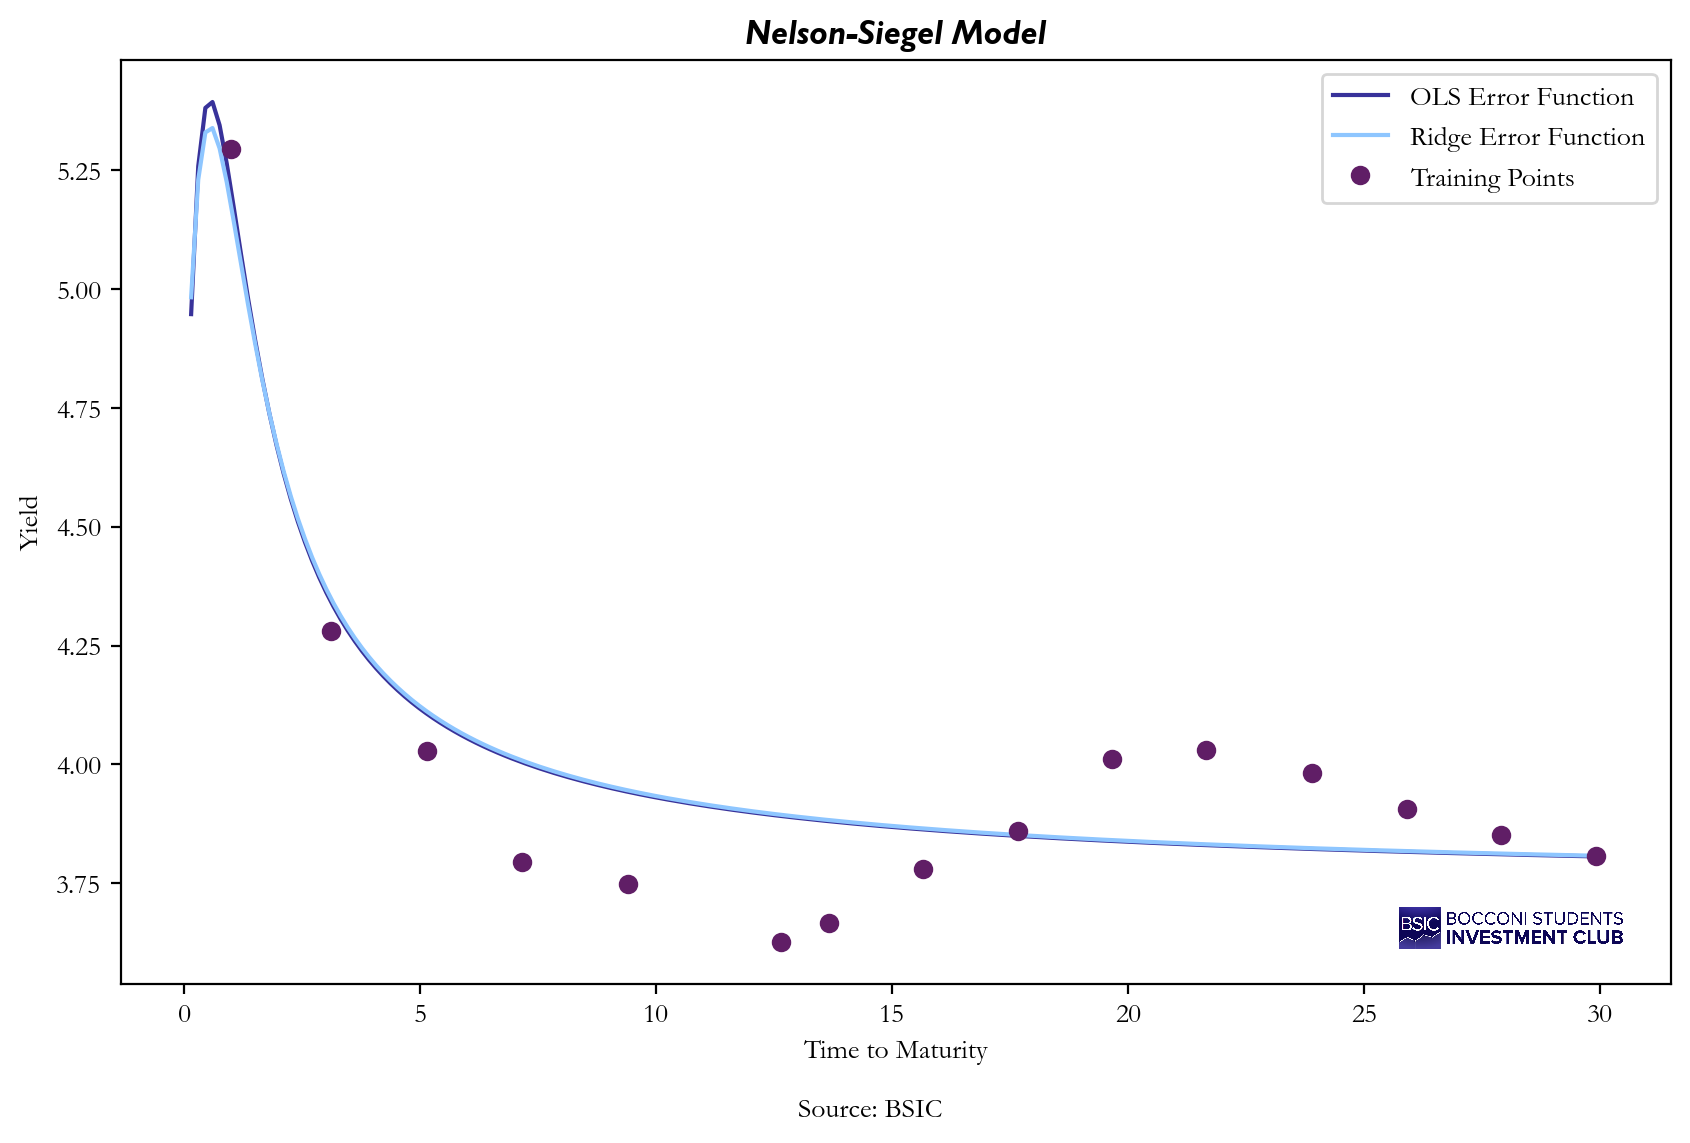

In [861]:
from mpl_bsic import apply_bsic_logo
from mpl_bsic import apply_bsic_style
import matplotlib.pyplot as plt

def plot_nelson_siegel(df, params, params_ridge):
    # optimize paramterers
    initial_params = [0.01, 0.01, 0.01, 1] 
    train_maturities = df['Time_to_Maturity']
    train_yields = df['Yield']
    
    # params for OLS
    result = minimize(
                    error_function_lambd,
                    initial_params,
                    args=(train_maturities, train_yields),  
                    method="L-BFGS-B",
                    options={'maxiter': 1000}, 
                )
    
    # params fo ridge
    result = params.iloc[289]
    result_ridge = params_ridge.iloc[289]
    
    x = np.linspace(0, 30, 200)
    y = np.array([nelson_siegel_lambd(result, x_i) for x_i in x])
    y_ridge = np.array([nelson_siegel_lambd(result_ridge, x_i) for x_i in x])
    
    fig, ax = plt.subplots(figsize = (10, 6), dpi =200)
    ax.plot(x, y, label = 'OLS Error Function')
    ax.plot(x, y_ridge, label = 'Ridge Error Function')
    ax.plot(df['Time_to_Maturity'], df['Yield'], 'o', label = 'Training Points')
    ax.set_xlabel('Time to Maturity')
    ax.set_ylabel('Yield')
    ax.set_title('Nelson-Siegel Model')
    ax.legend()
    apply_bsic_style(fig, ax)
    apply_bsic_logo(fig, ax, location='bottom right')

    
plot_nelson_siegel(df_to_plot, params, params_ridge)

## Factor Model

In [862]:
# clean the dataset of factors
loadings_df = pd.DataFrame(index = params.index)
loadings_df['Beta0 (Level)'] = np.array(params['Beta0 (Level)'])
loadings_df['Beta1 (Slope)'] = (np.array(params['Beta1 (Slope)'])) 
loadings_df['Beta2 (Curvature)'] = np.array(params['Beta2 (Curvature)'])
loadings_df['Lambda'] = (np.array(params['Lambda']))

In [863]:
# clean the dataset of factors from ridge model
loadings_df_ridge = pd.DataFrame(index = params.index)
loadings_df_ridge['Beta0 (Level)'] = np.array(params_ridge['Beta0 (Level)'])
loadings_df_ridge['Beta1 (Slope)'] = np.array(params_ridge['Beta1 (Slope)'])
loadings_df_ridge['Beta2 (Curvature)'] = np.array(params_ridge['Beta2 (Curvature)']) 
loadings_df_ridge['Lambda'] = (np.array(params_ridge['Lambda']))

## Returns

In [864]:
# Get dataset of returns
# Function to compute returns
def compute_gross_returns(prices, coupons):
    # Get Daily Coupons
    daily_coupons = coupons/365
    
    # compute returns with formula (R_(t, t+1) = P_(t+1) + c  - P_(t) / P(t))
    returns = (prices + daily_coupons - prices.shift(1))/prices.shift(1)
    
    return returns 

gross_returns = compute_gross_returns(prices,coupons)
carry = (coupons/365)/prices.shift(1)


## Rolldown Computation

In [865]:
def decompose_date(date: datetime.date):
    return date.day, date.month, date.year

In [900]:
# price a bond
def price_bond(price, current_date, time_to_maturity, maturity_date, coupon, issue_date, params, ytm = None):
    # key data
    if pd.isna(price) or pd.isna(coupon) or price <= 0:
        return np.nan
        
    calendar = ql.UnitedStates(ql.UnitedStates.NYSE)  # calendar to follow for calculations (NYSE)
    day_count_convention = ql.ActualActual(ql.ActualActual.Bond)  # the day count convention as specified in the bond
    
    day, month, year = decompose_date(current_date)
    evaluation_date = ql.Date(day, month, year)
    ql.Settings.instance().evaluationDate = evaluation_date
    
    # initialize bond data
    d, m, y = decompose_date(issue_date)
    issue_date = ql.Date(d, m, y)
    
    d, m, y = decompose_date(maturity_date)
    maturity_date = ql.Date(d, m, y)
    
    if evaluation_date == maturity_date:
        return np.nan
    
    tenor = ql.Period(ql.Semiannual)  # coupon frequency (semiannual)
    date_generation = ql.DateGeneration.Backward
    bussinessConvention = ql.Following
    month_end = False
    face_value = 100
    
    coupon = coupon
    
    if ytm == None:
        # compute ytm with nelson siegel
        ytm = nelson_siegel_lambd(params, time_to_maturity)/100

    # create the schedule for the bond
    schedule = ql.Schedule(issue_date, maturity_date, tenor, calendar, bussinessConvention, bussinessConvention,
                           date_generation, month_end)

    # Create the bond
    bond = ql.FixedRateBond(
        settlementDays=1,
        faceAmount=face_value,
        schedule=schedule,
        coupons=[coupon],
        paymentDayCounter=day_count_convention
    )
    
    return bond.cleanPrice(ytm, day_count_convention, ql.Compounded, ql.Semiannual)

In [911]:
# compute rolldown
def compute_rolldown(yields, prices, time_to_maturities, coupons, maturities_date, issue_date_df, loadings_df):
    
    rolldown_returns = pd.DataFrame(index = prices.index, columns = prices.columns)
    rolldown_prices = pd.DataFrame(index = prices.index, columns = prices.columns)
    
    # iterate over each column
    for i in range(prices.shape[1]):
        maturity_date = maturities_date.iloc[0, i]
        issue_date = issue_date_df.iloc[0, i]
        # iterate over each row
        for j in range(1, prices.shape[0]):
            # Handle nans
            if pd.isna(prices.iloc[j, i]) or pd.isna(prices.iloc[j-1, i]) or not isinstance(prices.iloc[j, i], (float, int)):
                rolldown_returns.iloc[j, i] = np.nan
                continue
            
            # maturity date 
            if pd.isna(maturity_date):
                # Get the boolean mask of non-NaT values
                not_nat_indices = maturities_dates.iloc[:, i].notna()
            
                # Get the integer indices of non-NaT values
                valid_indices = not_nat_indices[not_nat_indices].index
            
                # Access the first valid (non-NaT) value
                maturity_date = maturities_dates.loc[valid_indices[0]]
                maturity_date = maturity_date.iloc[i]
                
            # maturity date 
            if pd.isna(issue_date):
                # Get the boolean mask of non-NaT values
                not_nat_indices = issue_dates.iloc[:, i].notna()
            
                # Get the integer indices of non-NaT values
                valid_indices = not_nat_indices[not_nat_indices].index
            
                # Access the first valid (non-NaT) value
                issue_date = issue_date_df.loc[valid_indices[0]]
                issue_date = issue_date.iloc[i]
                
            # Current date
            date_t = prices.index[j]
            
            
            # time to maturity at time t
            time_to_maturity = time_to_maturities.iloc[j, i]

            # actual ytm
            ytm_t = yields.iloc[j, i]/100
            
            # Price at time t-1
            price_t_minus_1 = prices.iloc[j-1, i]
            
            # Coupon at time t
            coupons_t = coupons.iloc[j, i]/100
            
            # Params at time t - 1
            params = loadings_df.iloc[j]
            
            # bond pricing at time t
            try:
                price_t = price_bond(prices.iloc[j, i], date_t, time_to_maturity, maturity_date, coupons_t, issue_date, params, ytm_t)
            except Exception as e:
                print(f"Error pricing bond at ({j}, {i}): {e}")
                rolldown_returns.iloc[j, i] = np.nan
                continue
            
            # Compute rolldown return
            rolldown_returns.iloc[j, i] = (price_t / price_t_minus_1) - 1
            rolldown_prices.iloc[j, i] = price_t
        print(i)
    return rolldown_returns, rolldown_prices

In [912]:
rolldown, rolldown_price = compute_rolldown(yields, prices, time_to_maturities, coupons, maturities_dates, issue_dates, loadings_df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
Error pricing bond at (66, 52): non tradable at August 15th, 2022 (maturity being August 15th, 2022)
52
Error pricing bond at (132, 53): non tradable at November 15th, 2022 (maturity being November 15th, 2022)
53
Error pricing bond at (198, 54): non tradable at February 15th, 2023 (maturity being February 15th, 2023)
54
Error pricing bond at (327, 55): non tradable at August 15th, 2023 (maturity being August 15th, 2023)
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173

In [913]:
systematic_returns = rolldown + carry
idio_returns = gross_returns - systematic_returns

In [914]:
import statsmodels.api as sm

def rolling_regression(returns, systematic_returns, window_size=252):
    
    # Initialize data structures to store loadings
    loading_dataset = pd.DataFrame(index=returns.index[window_size:], columns=returns.columns[1:])
    alpha_dataset = pd.DataFrame(index=returns.index[window_size:], columns=returns.columns[1:])
    #Initialize dataset to store % variance explained
    variance_explained = pd.DataFrame(index=returns.index[window_size:], columns=returns.columns[1:])
    
    # Iterate over each asset (column in `returns`)
    for col in systematic_returns.columns[1:]:
        y = returns[col]
        x = systematic_returns[col]
        # Perform rolling window regression
        for i in range(window_size, len(returns)):
            
            # Handle Nans
            if pd.isna(returns.loc[returns.index[i], col]):
                loading_dataset.loc[returns.index[i], col] = np.nan
                alpha_dataset.loc[returns.index[i], col] = np.nan
                variance_explained.loc[returns.index[i], col] = np.nan
                continue
                    
            # Select rolling window data
            y_window = y.iloc[i - window_size:i].dropna()
            X_window = x.iloc[i - window_size:i].dropna()
            X_window = sm.add_constant(X_window)
            # Ensure all columns in X_window are numeric
            X_window = X_window.apply(pd.to_numeric, errors="coerce")
            # ensure both windows have same dimension        
            common_index = y_window.index.intersection(X_window.index)
            y_window = y_window.loc[common_index]
            X_window = X_window.loc[common_index]
            
            # Handle Nans if window length is not enough to perform the regression
            if y_window.shape[0] < window_size * 0.5:
                loading_dataset.loc[returns.index[i], col] = np.nan
                alpha_dataset.loc[returns.index[i], col] = np.nan
                variance_explained.loc[returns.index[i], col] = np.nan
                continue
            
            # Ensure all columns in X_window are numeric
            X_window = X_window.apply(pd.to_numeric, errors="coerce")
            
            # Perform regression
            model = sm.OLS(y_window, X_window).fit()

            # Store coefficients for each factor
            alpha_dataset.loc[returns.index[i], col] = model.params[0]
            loading_dataset.loc[returns.index[i], col] = model.params[1]
            
    return loading_dataset, alpha_dataset, variance_explained

In [915]:
loading_datasets, alpha_dataset, variance_explained = rolling_regression(gross_returns, systematic_returns)

In [917]:
loading_datasets.mean().mean()

0.9977525219525112